<a href="https://colab.research.google.com/github/sidereomundi/RedSequence/blob/main/red_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install emcee pygtc
from astropy.table import Table
import numpy as np
from matplotlib import pyplot as plt
import emcee
import pygtc
from tqdm import tqdm
from scipy.interpolate import interp1d
from google.colab import drive
from astropy.stats import sigma_clip
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 8.2 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
cosmos = Table.read("/content/drive/My Drive/ObservationalCosmology/Photo-z/cosmosM.fit")
cosmos[0:3]

Farmer,RAJ2000,DEJ2000,FModel,SolModel,loglpMassmed,EZzphot,EZzphotchi2,EZrestU,EZrestV,EZrestJ
,deg,deg,,,log(solMass),,,uJy,uJy,uJy
int32,float64,float64,uint8,bytes20,float64,float64,float64,float64,float64,float64
1,150.47763832,2.32896345,0,PointSource,8.57070,1.598163,2.26502e+02,1.82734e-01,3.18898e-01,2.65884e-01
2,150.47797399,2.32916870,0,PointSource,5.51014,0.111465,4.17790e+02,3.77805e-02,4.07147e-02,3.37495e-02
3,150.47711083,2.32966723,2,ExpGalaxy,--,--,--,--,--,--


In [3]:
U = -2.5*np.log10(cosmos["EZrestU"]) + 23.9
V = -2.5*np.log10(cosmos["EZrestV"]) + 23.9
J = -2.5*np.log10(cosmos["EZrestJ"]) + 23.9
cosmos["U"] = U
cosmos["V"] = V
cosmos["J"] = J
z = cosmos["EZzphot"]
cut = (cosmos["EZzphot"]<1.5) & (cosmos["SolModel"] != "PointSource") & (cosmos["FModel"] == 0) & (cosmos["loglpMassmed"] > 8.5)
#cut = np.isfinite(U)

def UVJsel(cosmos):
    passive = np.zeros(len(cosmos),dtype=bool)
    U = -2.5*np.log10(cosmos["EZrestU"]) + 23.9
    V = -2.5*np.log10(cosmos["EZrestV"]) + 23.9
    J = -2.5*np.log10(cosmos["EZrestJ"]) + 23.9
    z = cosmos["EZzphot"]
    passive[((U -V) > (0.88*(V - J) + 0.69)) & (0.0 < z) & (z < 0.5) & (U-V>1.3) & (V-J<1.6)] = True
    passive[((U -V) > 0.88*(V - J) + 0.59) & (0.5 <= z) & (z < 1.0) & (U-V>1.3) & (V-J<1.6)] = True
    passive[((U -V) > 0.88*(V - J) + 0.49) & (1.0 <= z) & (z < 2.0) & (U-V>1.3) & (V-J<1.6)] = True
    cosmos["passive"] = passive
#    return(passive)
UVJsel(cosmos)

<ipython-input-3-446c9a78656f>:1: RuntimeWarning: invalid value encountered in log10
  U = -2.5*np.log10(cosmos["EZrestU"]) + 23.9
<ipython-input-3-446c9a78656f>:2: RuntimeWarning: invalid value encountered in log10
  V = -2.5*np.log10(cosmos["EZrestV"]) + 23.9
<ipython-input-3-446c9a78656f>:3: RuntimeWarning: invalid value encountered in log10
  J = -2.5*np.log10(cosmos["EZrestJ"]) + 23.9
<ipython-input-3-446c9a78656f>:13: RuntimeWarning: invalid value encountered in log10
  U = -2.5*np.log10(cosmos["EZrestU"]) + 23.9
<ipython-input-3-446c9a78656f>:14: RuntimeWarning: invalid value encountered in log10
  V = -2.5*np.log10(cosmos["EZrestV"]) + 23.9
<ipython-input-3-446c9a78656f>:15: RuntimeWarning: invalid value encountered in log10
  J = -2.5*np.log10(cosmos["EZrestJ"]) + 23.9


In [4]:
def plotz05():
    x = np.linspace(-5,5,1000)
    y = np.zeros_like(x)
    y = (0.88*x + 0.69)
    y[y<1.3] = 1.3
    x[x>1.6] = 1.6
    return x,y

def plotz10():
    x = np.linspace(-5,5,1000)
    y = np.zeros_like(x)
    y = (0.88*x + 0.59)
    y[y<1.3] = 1.3
    x[x>1.6] = 1.6
    return x,y

def plotz20():
    x = np.linspace(-5,5,1000)
    y = np.zeros_like(x)
    y = (0.88*x + 0.49)
    y[y<1.3] = 1.3
    x[x>1.6] = 1.6
    return x,y

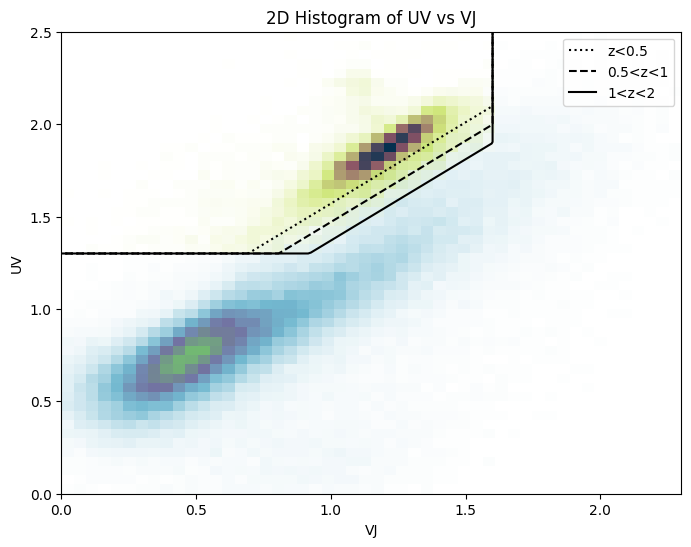

In [5]:
UV = U[cut]-V[cut]
VJ = V[cut]-J[cut]
#plt.plot(VJ,UV,'.',alpha=0.1)
#plt.plot(cosmos["V"][cosmos["passive"]]-cosmos["J"][cosmos["passive"]], cosmos["U"][cosmos["passive"]]-cosmos["V"][cosmos["passive"]],'.',alpha=0.01)
#plt.ylim([0.8,2.2])

pcut = np.array(cosmos["passive"][cut])
plt.figure(figsize=(8, 6)) # Set the figure size, optional
plt.hist2d(VJ, UV, bins=50, cmap='ocean_r',range=[(0,2.3),(0,2.5)]) # Adjust the number of bins and colormap as needed
plt.hist2d(VJ[pcut], UV[pcut], bins=50, cmap='hot_r',range=[(0,2.3),(0,2.5)],alpha=0.45) # Adjust the number of bins and colormap as needed
#plt.plot(cosmos["V"][~cosmos["passive"]]-cosmos["J"][~cosmos["passive"]], cosmos["U"][~cosmos["passive"]]-cosmos["V"][~cosmos["passive"]],'g.',alpha=0.005)
#plt.plot(cosmos["V"][cosmos["passive"]]-cosmos["J"][cosmos["passive"]], cosmos["U"][cosmos["passive"]]-cosmos["V"][cosmos["passive"]],'r.',alpha=0.01)
#plt.colorbar() # Show the color bar representing the counts

x05,y05 = plotz05()
plt.plot(x05,y05,'k:',label='z<0.5')
x10,y10 = plotz10()
plt.plot(x10,y10,'k--',label='0.5<z<1')
x20,y20 = plotz20()
plt.plot(x20,y20,'k',label='1<z<2')

plt.ylabel('UV') # Set x-axis label
plt.xlabel('VJ') # Set y-axis label
plt.title('2D Histogram of UV vs VJ') # Set title

plt.legend()

In [6]:
cosmos = cosmos[cut]

In [14]:
filters = np.array([473, 642, 784, 926])
filters_b = np.array([398, 568, 710, 850])
filters_r = np.array([548, 716, 857, 1002])
print(filters_b/400-1)
print(filters_r/400-1)

[-0.005  0.42   0.775  1.125]
[0.37   0.79   1.1425 1.505 ]


In [15]:
MLAB = ["MAG_G","MAG_R","MAG_I","MAG_Z"]
MLABERR = ["MAGERR_G","MAGERR_R","MAGERR_I","MAGERR_Z"]

In [16]:
des = Table.read("/content/drive/My Drive/ObservationalCosmology/Photo-z/DEScosmosy3deep.fits")
des["MAG_G"] = des["BDF_MAG_G"]
des["MAG_R"] = des["BDF_MAG_R"]
des["MAG_I"] = des["BDF_MAG_I"]
des["MAG_Z"] = des["BDF_MAG_Z"]

des["MAGERR_G"] = des["BDF_MAG_ERR_DERED_G"]
des["MAGERR_R"] = des["BDF_MAG_ERR_DERED_R"]
des["MAGERR_I"] = des["BDF_MAG_ERR_DERED_I"]
des["MAGERR_Z"] = des["BDF_MAG_ERR_DERED_Z"]

mlim = [26.46,25.73,25.54,24.97]
blab = ["G","R","I","Z"]

for j,i in enumerate(blab):
    des = des[des["MAG_"+i]<mlim[j]]

for ilab in range(3):
    test = (
    (des[MLAB[ilab]] > 15) &
    (des[MLAB[ilab + 1]] > 15) &
    (des[MLABERR[ilab]] > 0) &
    (des[MLABERR[ilab + 1]] > 0)
    )
    des = des[test]

In [9]:
import astropy.units as u
from astropy.coordinates import SkyCoord

In [10]:
c1 = SkyCoord(cosmos["RAJ2000"], cosmos["DEJ2000"])
c2 = SkyCoord(des["RA"]*u.deg, des["DEC"]*u.deg)

In [11]:
max_sep = 1.0 * u.arcsec
idx, d2d, d3d = c1.match_to_catalog_sky(c2)
sep_constraint = d2d < max_sep
cosmosm = cosmos[sep_constraint]
desm = des[idx[sep_constraint]]

In [12]:
cosmosm[0:4], len(cosmosm)

(<Table length=4>
 Farmer   RAJ2000      DEJ2000    FModel ...      V            J       passive
            deg          deg             ...     uJy          uJy             
 int32    float64      float64    uint8  ...   float64      float64      bool 
 ------ ------------ ------------ ------ ... ------------ ------------ -------
     12 150.47679031   2.33150699      0 ...  2.39216e+01  2.36463e+01   False
     15 150.60559681   1.88581143      0 ...  2.28922e+01  2.24569e+01   False
     34 150.59908866   1.88614529      0 ...  2.26636e+01  2.10278e+01   False
     52 149.30978983   2.13032236      0 ...  2.14332e+01  2.08444e+01   False,
 102971)

In [17]:
desm[0:4]

RA,DEC,BDF_MAG_DERED_CALIB_G,BDF_MAG_DERED_CALIB_R,BDF_MAG_DERED_CALIB_I,BDF_MAG_DERED_CALIB_Z,BDF_MAG_ERR_DERED_G,BDF_MAG_ERR_DERED_R,BDF_MAG_ERR_DERED_I,BDF_MAG_ERR_DERED_Z,BDF_MAG_G,BDF_MAG_R,BDF_MAG_I,BDF_MAG_Z,MAG_G,MAG_R,MAG_I,MAG_Z,MAGERR_G,MAGERR_R,MAGERR_I,MAGERR_Z
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
150.47680700786628,2.3315306522121952,25.071049518404216,24.408716311341774,24.088582767145116,24.223029435768307,0.05265612892799698,0.05085797223074412,0.046975526656825244,0.07694827561923026,25.10729832014425,24.434574420482917,24.11168380604346,24.23628864069018,25.10729832014425,24.434574420482917,24.11168380604346,24.23628864069018,0.05265612892799698,0.05085797223074412,0.046975526656825244,0.07694827561923026
150.60568466927916,1.8856407287467396,23.697041702837282,23.579255747312658,23.183671211079364,22.846468747651215,0.019401092114943837,0.02846254843847424,0.02515395714468046,0.031538787683302635,23.742070380360566,23.61101119925862,23.211096049445352,22.86302385070139,23.742070380360566,23.61101119925862,23.211096049445352,22.86302385070139,0.019401092114943837,0.02846254843847424,0.02515395714468046,0.031538787683302635
150.59909992572432,1.8861437123234701,24.715521252763317,23.778982990434578,23.049183152444506,22.68465394729026,0.046827206670816766,0.03807790681293199,0.027251918503291058,0.032514414082669585,24.760419759497985,23.810651008140855,23.076543885987096,22.7011601852233,24.760419759497985,23.810651008140855,23.076543885987096,22.7011601852233,0.046827206670816766,0.03807790681293199,0.027251918503291058,0.032514414082669585
149.30978988781226,2.1303160878453165,22.63395417253479,21.857705358368516,21.481144134772748,21.413356109547518,0.010306575878157845,0.00920132851713845,0.008568621162315507,0.011393782609007311,22.68291985324591,21.89210525062269,21.51050781745817,21.431389133442842,22.68291985324591,21.89210525062269,21.51050781745817,21.431389133442842,0.010306575878157845,0.00920132851713845,0.008568621162315507,0.011393782609007311


In [19]:
test = (cosmosm["EZzphot"]<0.5) & (cosmosm["EZzphot"]>0.45) & (cosmosm["passive"] )

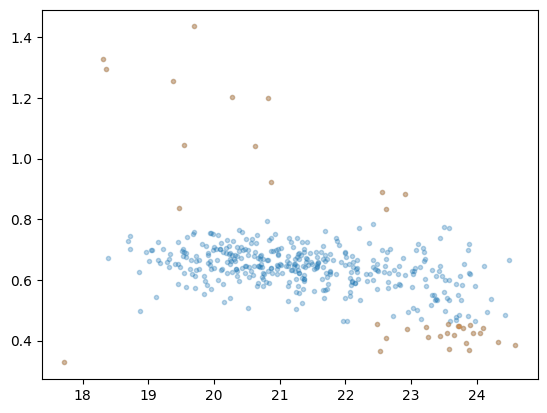

In [20]:
plt.plot(desm["MAG_I"][test],desm["MAG_R"][test]-desm["MAG_I"][test],'.',alpha=0.3)
sigmacl = sigma_clip(desm["MAG_R"][test]-desm["MAG_I"][test],sigma=3., cenfunc='median',stdfunc='mad_std',maxiters=None, masked=True)
sigmaclipped = sigmacl.mask
plt.plot(desm["MAG_I"][test][sigmaclipped],desm["MAG_R"][test][sigmaclipped]-desm["MAG_I"][test][sigmaclipped],'.',alpha=0.3)
#plt.ylim(-1,3)

(15.0, 25.0)

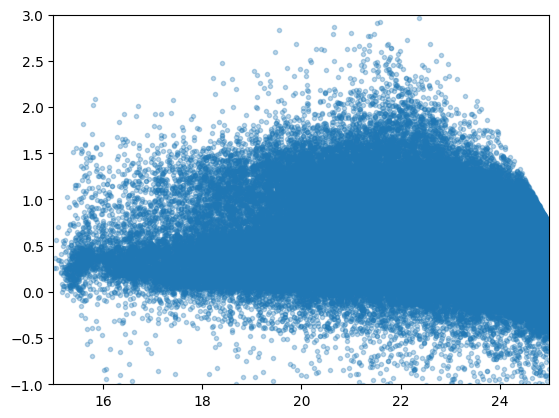

In [21]:
plt.plot(des["MAG_I"],des["MAG_R"]-des["MAG_I"],'.',alpha=0.3)
plt.ylim(-1,3)
plt.xlim(15,25)

(-1.0, 2.0)

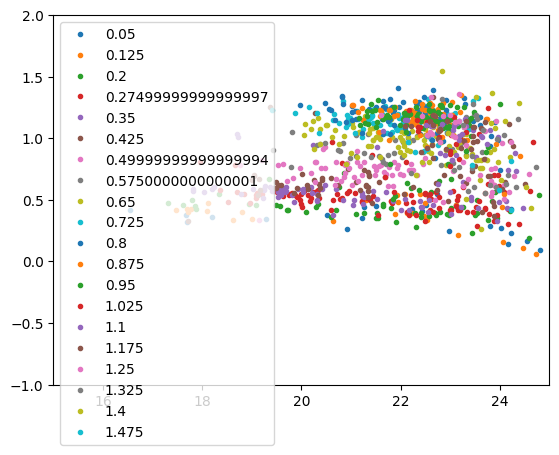

In [26]:

zrange = np.arange(0.05,1.5,0.075)
dz = zrange[1]-zrange[0]

for i,j in enumerate(zrange):
    test = (cosmosm["EZzphot"]<j+dz) & (cosmosm["EZzphot"]>=j) & (cosmosm["passive"])
    plt.plot(desm["MAG_I"][test][::10],desm["MAG_R"][test][::10]-desm["MAG_I"][test][::10],'.',alpha=1,label=str(j))
plt.legend()
plt.xlim(15,25)
plt.ylim(-1,2)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.stats import norm
from scipy.optimize import minimize

# Funzioni già definite
def CMRL(theta, x, y, xerr, yerr):
    A, B, s,p,m0,ds = theta
    ymod = A + B * (x-np.median(x))
    ymoderr2 = yerr**2 + s**2 + (xerr * B)**2
    return np.sum(np.log(p*norm.pdf(y, loc=ymod, scale=np.sqrt(ymoderr2))+(1-p)*norm.pdf(y, loc=m0, scale=s+ds)))

def CMRL_clipped(theta, x, y, xerr, yerr):
    A, B, s = theta
    ymod = A + B * (x-np.median(x))
    ymoderr2 = yerr**2 + s**2 + (xerr * B)**2
    return norm.logpdf(y, loc=ymod, scale=np.sqrt(ymoderr2)).sum()

def prior(theta):
    A, B, s,p,m0,ds = theta
    return 0 if (s > 0) & (ds>0) & (p>0) & (p<1) else -np.inf

def prior_clipped(theta):
    A, B, s = theta
    return 0 if (s > 0)  else -np.inf

def CMRp(theta, x, y, xerr, yerr):
    p = prior(theta)
    if p == 0:
        return CMRL(theta, x, y, xerr, yerr) + p
    else:
        return -np.inf

def CMRp_clipped(theta, x, y, xerr, yerr):
    p = prior_clipped(theta)
    if p == 0:
        return CMRL_clipped(theta, x, y, xerr, yerr) + p
    else:
        return -np.inf

In [28]:
results = np.zeros((len(zrange), 4, 3))  # 3 per ilab, 3 per A, B, s

# Loop su ilab
for ilab in range(3):
    for i, j in enumerate(zrange):


        test1 = np.where((cosmosm["EZzphot"] < (j + dz)) & (cosmosm["EZzphot"] >= j) & (cosmosm["passive"]))[0]
        sigmacl = sigma_clip(desm[MLAB[ilab]][test1]-desm[MLAB[ilab+1]][test1],sigma=3., cenfunc='median',stdfunc='mad_std',maxiters=None, masked=True)
        sigmaclipped = sigmacl.mask
        test = test1[sigmaclipped]
        x = desm[MLAB[ilab + 1]][test]
        y = desm[MLAB[ilab]][test] - desm[MLAB[ilab + 1]][test]
        xerr = desm[MLABERR[ilab + 1]][test]
        yerr = np.sqrt(desm[MLABERR[ilab]][test]**2 + desm[MLABERR[ilab + 1]][test]**2)

        if i==0:
            p0 = np.random.rand(6)
            p0[2] = np.abs(p0[2])  # Assicurati che s sia positivo
            p0[5] = np.abs(p0[5])  # Assicurati che ds sia positivo
        else:
            p0=soln.x
        np.random.seed(42)
        nll = lambda *args: -CMRp(*args)
        initial = p0
        soln = minimize(nll, initial, args=(x, y, xerr, yerr),method="Powell")
        results[i, 0:3, ilab] = soln.x[0:3]
        results[i, 3, ilab] = np.median(x)

# Creazione delle funzioni di interpolazione per ogni parametro e ogni ilab
interp_funcs = {}
for idx, param in enumerate(['A', 'B', 's','med']):
    interp_funcs[param] = [interp1d(zrange, results[:, idx, k], kind='quadratic', fill_value="extrapolate") for k in range(3)]

def CMR(z):
    """ Restituisce i valori interpolati di A, B, s, e med per ogni ilab dato un z. """
    return [func(z) for sublist in interp_funcs.values() for func in sublist]



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_optimize.py:2502: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_optimize.py:2502: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)
<ipython-input-27-96c838ffa3dd>:12: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(p*norm.pdf(y, loc=ymod, scale=np.sqrt(ymoderr2))+(1-p)*norm.pdf(y, loc=m0, scale=s+ds)))
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_optimize.py:2503: RuntimeWarning: invalid value encountered in scalar subtract
  p = (x - v) * tmp2 - (x - w) * tmp1
<ipython-input-27-96c838ffa3dd>:12: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(p*norm.pdf(y, loc=ymod, scale=np.sqrt(ymoderr2))+(1-p)*norm.pdf(y, loc=m0, scale=s+ds)))
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_optimize.py:2502: RuntimeWarning: invalid value

In [29]:
results = np.zeros((len(zrange), 4, 3))  # 3 per ilab, 3 per A, B, s

# Loop su ilab
for ilab in range(3):
    for i, j in enumerate(zrange):


        test = (cosmosm["EZzphot"] < (j + dz)) & (cosmosm["EZzphot"] >= j) & (cosmosm["passive"])
        x = desm[MLAB[ilab + 1]][test]
        y = desm[MLAB[ilab]][test] - desm[MLAB[ilab + 1]][test]

        xerr = desm[MLABERR[ilab + 1]][test]
        yerr = np.sqrt(desm[MLABERR[ilab]][test]**2 + desm[MLABERR[ilab + 1]][test]**2)

        if i==0:
            p0 = np.random.rand(3)
            p0[2] = np.abs(p0[2])  # Assicurati che s sia positivo
        else:
            p0=soln.x
        np.random.seed(42)
        nll = lambda *args: -CMRp_clipped(*args)
        initial = p0
        soln = minimize(nll, initial, args=(x, y, xerr, yerr),method="Powell")
        results[i, 0:3, ilab] = soln.x[0:3]
        results[i, 3, ilab] = np.median(x)

# Creazione delle funzioni di interpolazione per ogni parametro e ogni ilab
interp_funcs = {}
for idx, param in enumerate(['A', 'B', 's','med']):
    interp_funcs[param] = [interp1d(zrange, results[:, idx, k], kind='quadratic', fill_value="extrapolate") for k in range(3)]

def CMR(z):
    """ Restituisce i valori interpolati di A, B, s, e med per ogni ilab dato un z. """
    return [func(z) for sublist in interp_funcs.values() for func in sublist]



In [39]:
CMR(0.46)

[array(1.68229509),
 array(0.67367167),
 array(0.36781832),
 array(-0.05970722),
 array(-0.03610099),
 array(-0.0192287),
 array(0.18846064),
 array(0.1103665),
 array(0.04380601),
 array(21.97896507),
 array(21.2985034),
 array(20.92829907)]

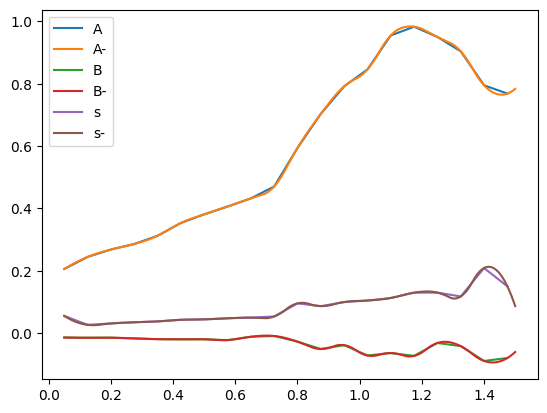

In [32]:
|# Plot dei risultatia
iilab = 2
zz = np.linspace(0.05,1.5,1000)
plt.plot(zrange, results[:, 0,iilab], label='A')
plt.plot(zz, CMR(zz)[iilab], label='A-')
plt.plot(zrange, results[:, 1,iilab], label='B')
plt.plot(zz, CMR(zz)[iilab+3], label='B-')
plt.plot(zrange, results[:, 2,iilab], label='s')
plt.plot(zz, CMR(zz)[iilab+6], label='s-')
plt.legend()
plt.show()


In [45]:
def model(z,ilab):
    vec = CMR(z)
    x = sptcat[MLAB[ilab+1]]
    y = sptcat[MLAB[ilab]] - sptcat[MLAB[ilab+1]]
    A = vec[ilab]
    B = vec[ilab+3]
    s = vec[ilab+6]
    med = vec[ilab+9]
    ymod = A + B * (x-med)
    return x,ymod,s

zlim = [0.,0.37,0.79,1.5]
def like_p_of_z(theta,sptcat):
    z,p,s0,s1,s2 = theta
    logl = np.zeros(3)
    vec = CMR(z)
    for ilab in [0,1,2]:
        x = sptcat[MLAB[ilab+1]]
        y = sptcat[MLAB[ilab]] - sptcat[MLAB[ilab+1]]
        xerr = sptcat[MLABERR[ilab+1]]
        yerr = np.sqrt(sptcat[MLABERR[ilab]]**2+sptcat[MLABERR[ilab+1]]**2)
        A = vec[ilab]
        B = vec[ilab+3]
#        if z<zlim[ilab+1]:
        s = vec[ilab+6]
#        else:
#            s = 100.
        med = vec[ilab+9]
        ymod = A + B * (x-med)
        ymoderr2 = yerr**2 + s**2 + (xerr * B)**2
        sigma = theta[2+ilab]
#        logl[ilab]= np.sum(np.log(p*norm.pdf(y, loc=ymod, scale=np.sqrt(ymoderr2))+(1-p)*(1/sigma)))
        logl[ilab]= np.sum(np.log(p*norm.pdf(y, loc=ymod, scale=np.sqrt(ymoderr2))+(1-p)*norm.pdf(y, loc=np.median(y), scale=sigma)))
    return np.sum(logl)

def prior_p_of_z(theta):
    z,p,s0,s1,s2 = theta
    if (z>0) & (z<1.2) & (p>0) & (p<1) & (s0>0) & (s1>0) & (s2>0):
        return 0
    else:
        return -np.inf

def post_p_of_z(theta,sptcat):
    lp = prior_p_of_z(theta)
    ll = like_p_of_z(theta,sptcat)
    if np.isfinite(lp+ll):
        return lp+ll
    else:
        return -np.inf

In [46]:
y6lim = [24.5,24,23.4,22.75]
from astropy.table import Table
sptcat = Table.read("/content/drive/My Drive/ObservationalCosmology/Photo-z/sptclust.0.60.fits")
sptcat = sptcat[(sptcat["FLAGS_FOOTPRINT"]==1) & (sptcat["FLAGS_GOLD"] == 0)& (sptcat["FLAGSTR"] == "ok") & (sptcat["FLAGS_FOREGROUND"] == 0) &
(sptcat["FITVD_FLAGS"] == 0) &  (sptcat["MASK_FLAGS"] == 0) & (np.abs(sptcat["SPREADERR_MODEL_G"]) <0.1) &
(sptcat["MAGERR_AUTO_G"] > 0) & (sptcat["MAGERR_AUTO_R"] > 0) & (sptcat["MAGERR_AUTO_I"] > 0) & (sptcat["MAGERR_AUTO_Z"] > 0)
& (sptcat["MAG_AUTO_G"] <y6lim[0]) & (sptcat["MAG_AUTO_R"] <y6lim[1]) & (sptcat["MAG_AUTO_I"] <y6lim[2]) & (sptcat["MAG_AUTO_Z"] <y6lim[3])]
#& (np.abs(sptcat["DEC"]-np.median(sptcat["DEC"]))<1./60) &
#(np.abs((sptcat["RA"]-np.median(sptcat["RA"]))*np.cos(np.deg2rad(np.median(sptcat["DEC"]))))<1./60)]
#sptcat

sptcat["MAG_G"] = sptcat["BDF_MAG_G_CORRECTED"]
sptcat["MAG_R"] = sptcat["BDF_MAG_R_CORRECTED"]
sptcat["MAG_I"] = sptcat["BDF_MAG_I_CORRECTED"]
sptcat["MAG_Z"] = sptcat["BDF_MAG_Z_CORRECTED"]

# sptcat["MAG_G"] = sptcat["MAG_AUTO_G"]
# sptcat["MAG_R"] = sptcat["MAG_AUTO_R"]
# sptcat["MAG_I"] = sptcat["MAG_AUTO_I"]
# sptcat["MAG_Z"] = sptcat["MAG_AUTO_Z"]

sptcat["MAGERR_G"] = sptcat["BDF_MAG_ERR_G"]
sptcat["MAGERR_R"] = sptcat["BDF_MAG_ERR_R"]
sptcat["MAGERR_I"] = sptcat["BDF_MAG_ERR_I"]
sptcat["MAGERR_Z"] = sptcat["BDF_MAG_ERR_Z"]
#MLAB = ["MAG_AUTO_G","MAG_AUTO_R","MAG_AUTO_I","MAG_AUTO_Z"]
#MLABERR = ["MAGERR_AUTO_G","MAGERR_AUTO_R","MAGERR_AUTO_I","MAGERR_AUTO_Z"]
#MLABERR = ["BDF_MAG_ERR_G","BDF_MAG_ERR_R","BDF_MAG_ERR_I","BDF_MAG_ERR_Z"]

print(post_p_of_z([0.25,0.9,1,1,1],sptcat),post_p_of_z([0.41,0.9,1,1,1],sptcat),post_p_of_z([0.93,0.9,1,1,1],sptcat))

-1361.7247035521482 -1587.1217035462091 -3269.744597967983


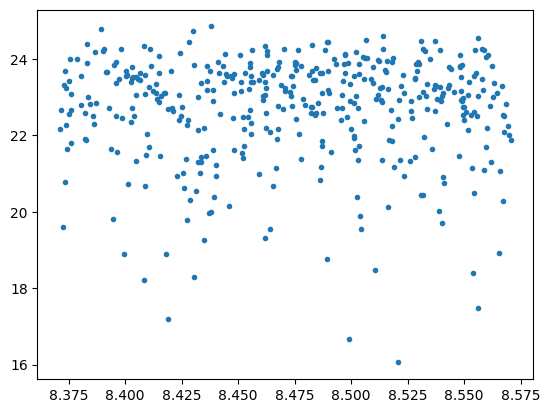

In [48]:
plt.plot(sptcat['RA'],sptcat['MAG_G'],'.')

In [49]:
nll = lambda *args: -post_p_of_z(*args)
#soln = minimize(nll,[0.4,0.9,1,1,1], args=(sptcat),method="Powell")
#soln = minimize(nll,soln.x , args=(sptcat),method="Nelder-Mead")
#soln = minimize(nll,[0.5,0.1,0.4,0.175,0.15] , args=(sptcat),method="Nelder-Mead")
initial = [0.1,0.1,0.4,0.175,0.15]
bestf = np.inf
bestp = initial
soln = minimize(nll,initial , args=(sptcat))
for i in np.arange(0.1,1.3,0.1):
    initial[0] = i
    soln = minimize(nll,initial , args=(sptcat))
    if soln.fun < bestf:
        bestp = soln.x
        bestf = soln.fun
soln = minimize(nll,bestp , args=(sptcat))
print(soln, post_p_of_z(soln.x,sptcat))

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtrac

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 231.90952492192676
        x: [ 6.207e-01  7.057e-02  4.394e-01  2.867e-01  1.674e-01]
      nit: 1
      jac: [ 5.722e-06 -1.907e-06  1.526e-05 -7.629e-06  1.717e-05]
 hess_inv: [[ 6.525e-01 -5.425e-01 ... -5.900e-01  1.525e+00]
            [-5.425e-01  8.725e-01 ...  2.300e-01 -4.250e-01]
            ...
            [-5.900e-01  2.300e-01 ...  1.840e+00 -1.900e+00]
            [ 1.525e+00 -4.250e-01 ... -1.900e+00  5.250e+00]]
     nfev: 287
     njev: 46 -231.90952492192676


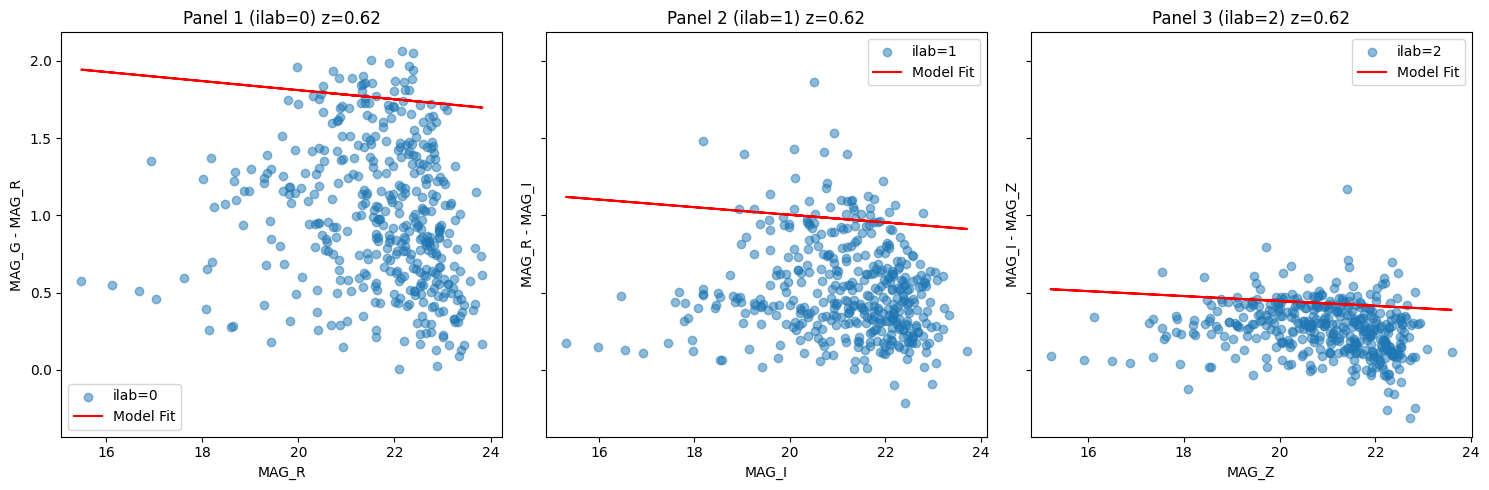

0.6206773374457688


In [50]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for ilab in range(3):
    x = sptcat[MLAB[ilab + 1]]
    y = sptcat[MLAB[ilab]] - sptcat[MLAB[ilab + 1]]
    xmod, ymod, s = model(soln.x[0], ilab)

    ax = axes[ilab]
    ax.scatter(x, y, alpha=0.5, label=f'ilab={ilab}')
    ax.plot(xmod, ymod, color='red', label='Model Fit')
    ax.set_title(f'Panel {ilab + 1} (ilab={ilab}) z={round(soln.x[0],2)}')
    ax.set_xlabel(MLAB[ilab + 1])
    ax.set_ylabel(f'{MLAB[ilab]} - {MLAB[ilab + 1]}')
    ax.legend()

plt.tight_layout()
plt.show()

print(soln.x[0])

 17%|█▋        | 87/500 [00:11<02:07,  3.25it/s]<ipython-input-45-c54cad83f8f1>:33: RuntimeWarning: invalid value encountered in log
  logl[ilab]= np.sum(np.log(p*norm.pdf(y, loc=ymod, scale=np.sqrt(ymoderr2))+(1-p)*norm.pdf(y, loc=np.median(y), scale=sigma)))
100%|██████████| 500/500 [00:54<00:00,  9.25it/s]


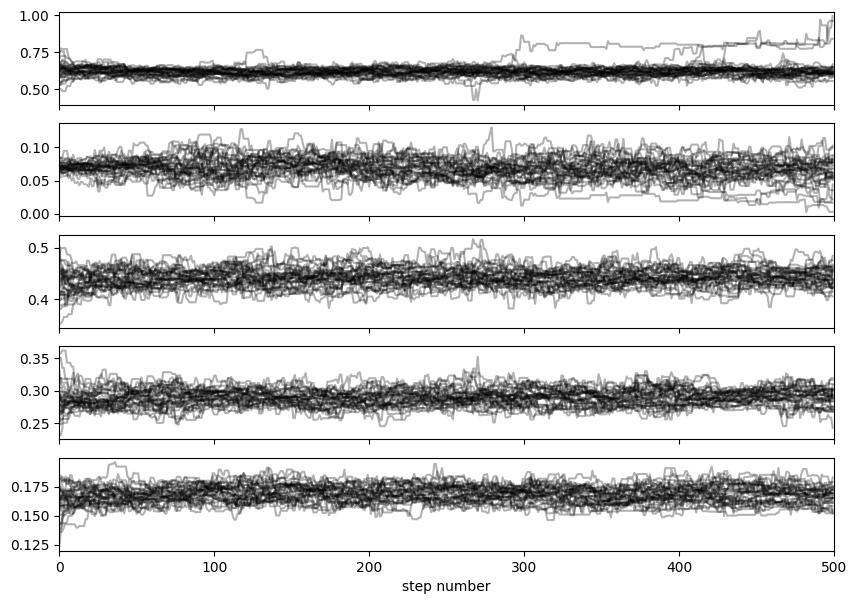

In [51]:
pos = soln.x * (1+1e-1 * np.random.randn(32, 5))
#pos = [0.2,0.9,1]
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, post_p_of_z, args=([sptcat]))
sampler.run_mcmc(pos, 500, progress=True);
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(array([3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 1.600e+01, 1.200e+01, 6.200e+01, 1.780e+02,
        3.480e+02, 5.410e+02, 8.770e+02, 1.163e+03, 1.442e+03, 1.465e+03,
        1.329e+03, 9.820e+02, 4.570e+02, 2.050e+02, 7.700e+01, 3.100e+01,
        1.100e+01, 6.000e+00, 5.000e+00, 1.000e+01, 1.000e+00, 1.100e+01,
        2.900e+01, 6.800e+01, 7.100e+01, 1.320e+02, 1.300e+01, 2.100e+01,
        1.100e+01, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.42446188, 0.43590006, 0.44733824, 0.45877642, 0.4702146 ,
        0.48165278, 0.49309096, 0.50452914, 0.51596732, 0.5274055 ,
        0.53884367, 0.55028185, 0.56172003, 0.57315821, 0.58459639,
        0.59603457, 0.60747275, 0.61891093, 0.63034911, 0.64178729,
        0.65322547, 0.66466365, 0.67610182, 0.68754   , 0.69897818,
        0.71041636, 0.72185454, 0.73

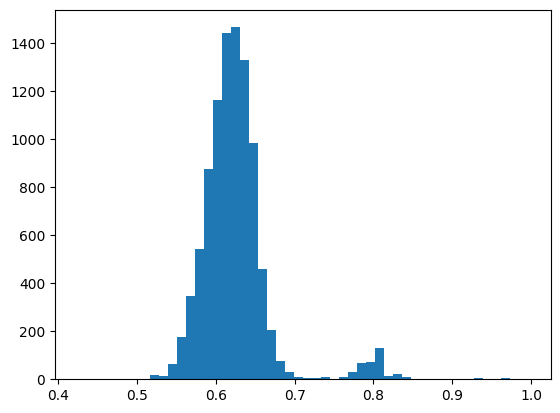

In [53]:
flat_samples = sampler.get_chain(flat=True,discard=200)
plt.hist(flat_samples[:,0],bins=50)

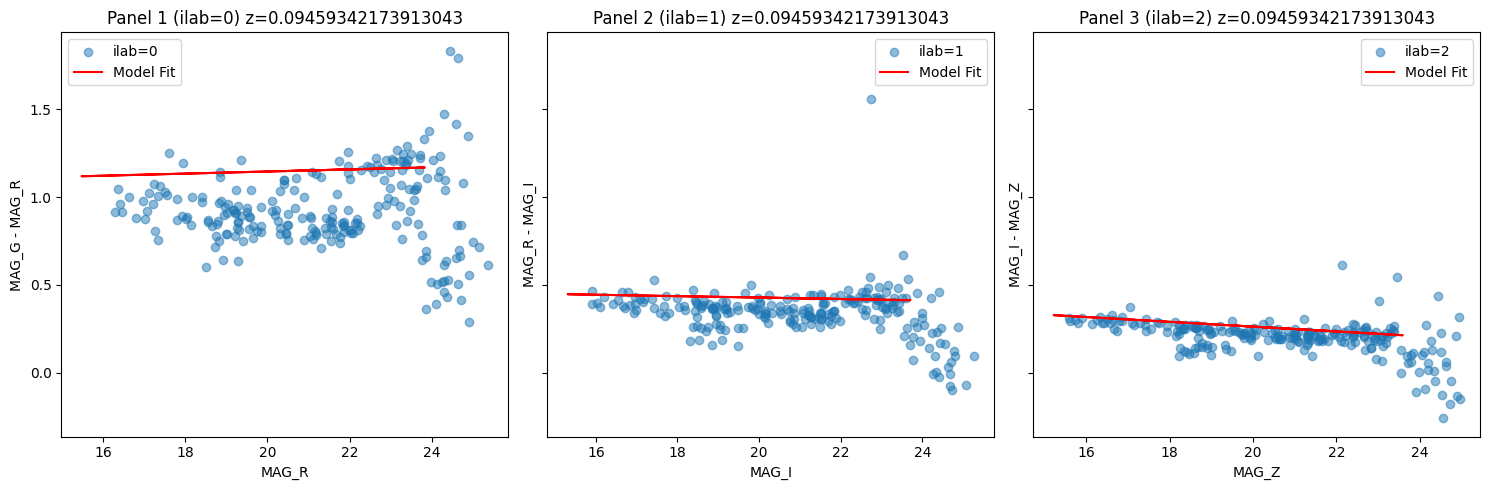

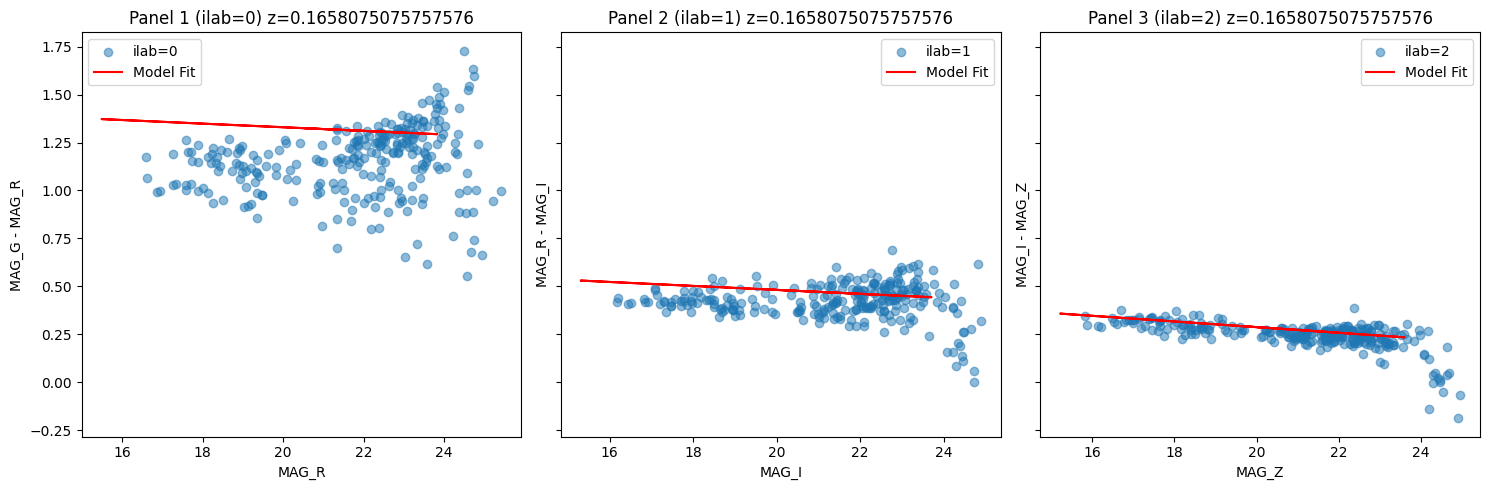

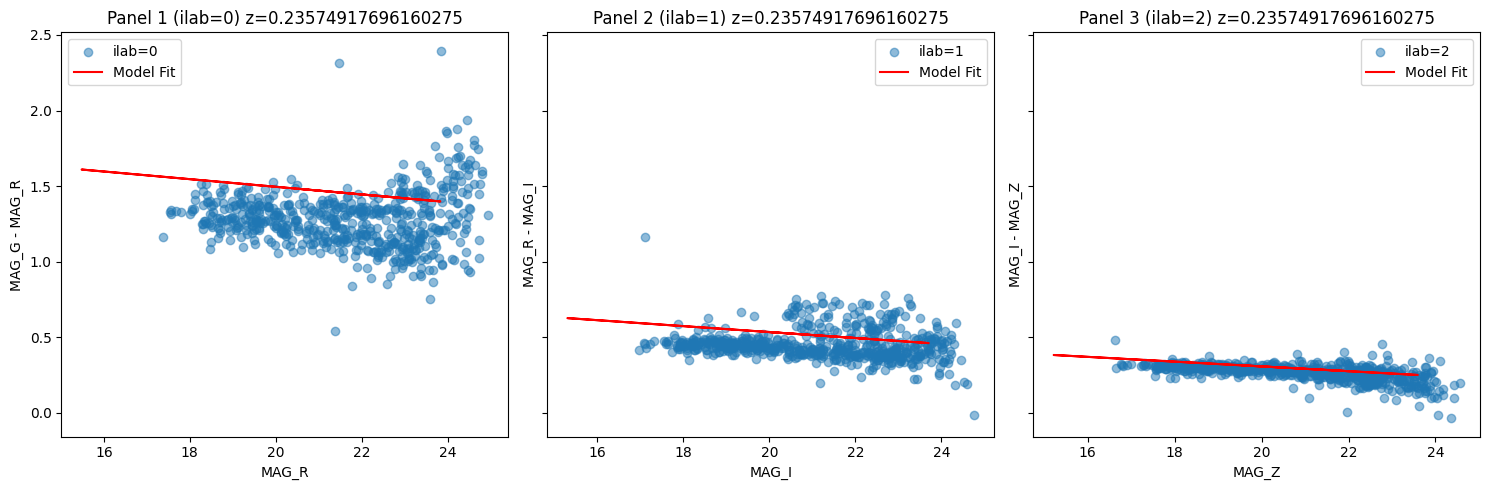

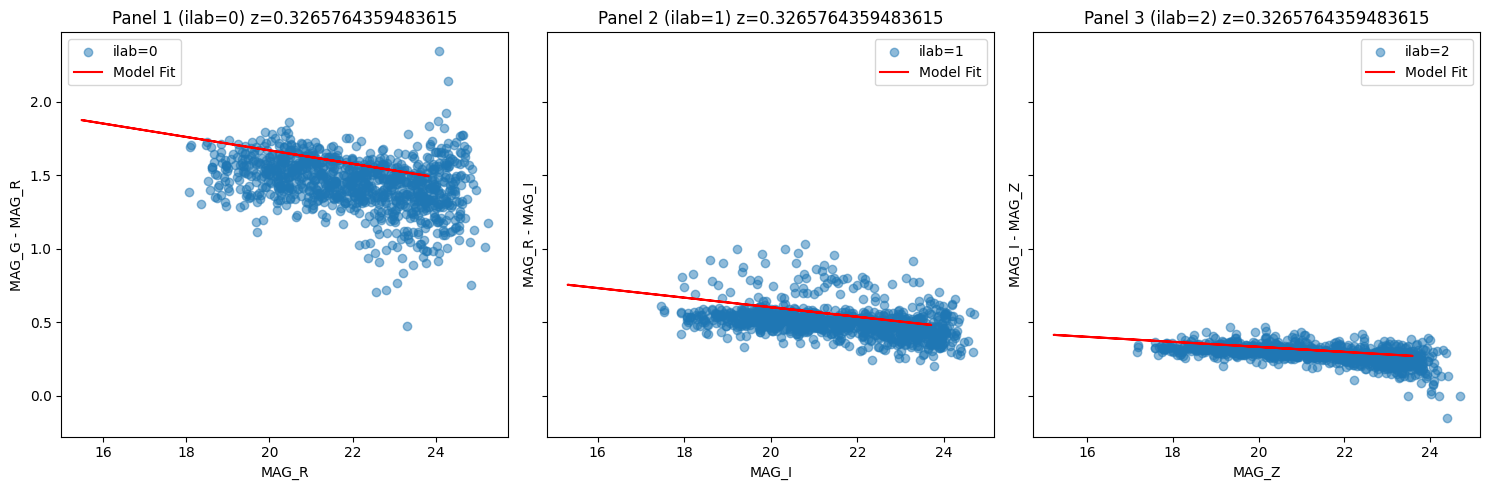

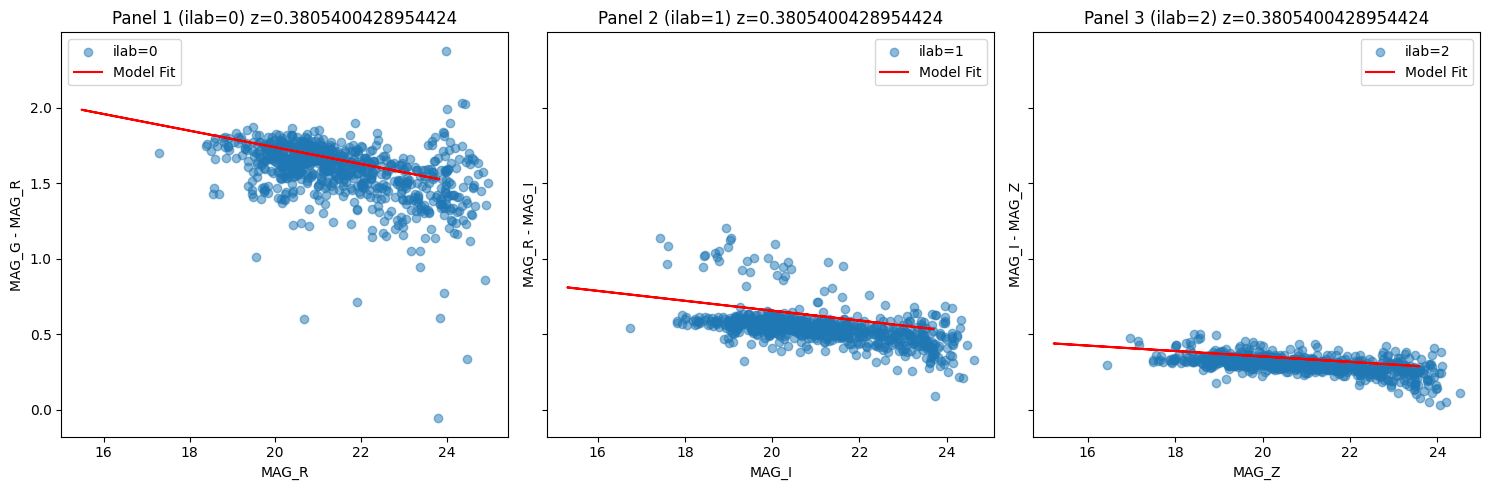

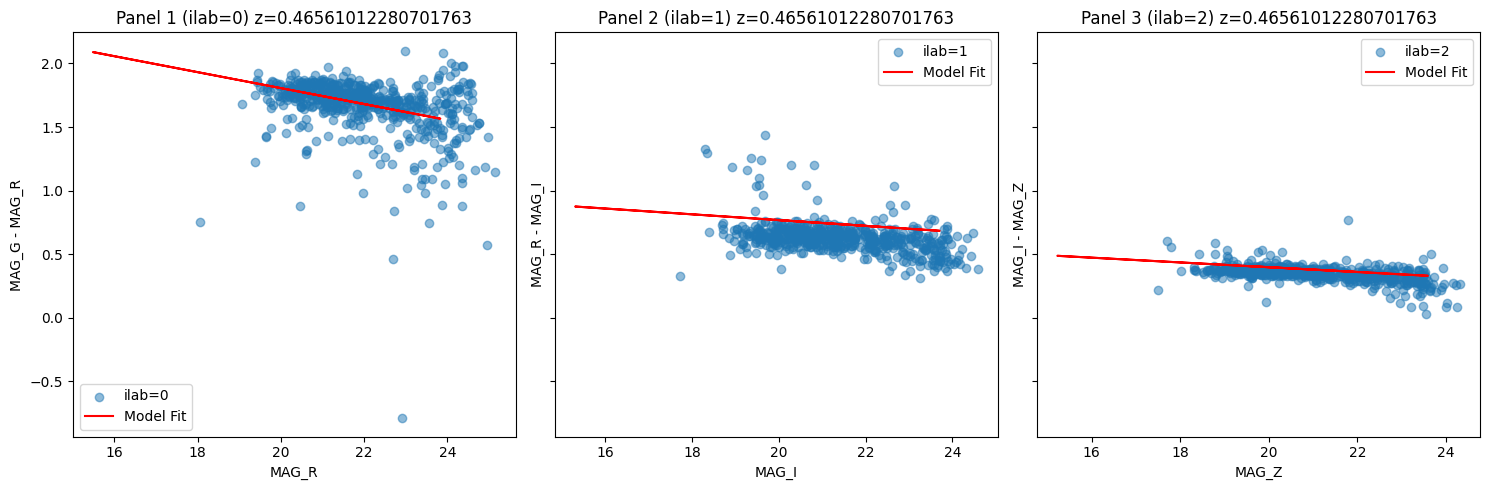

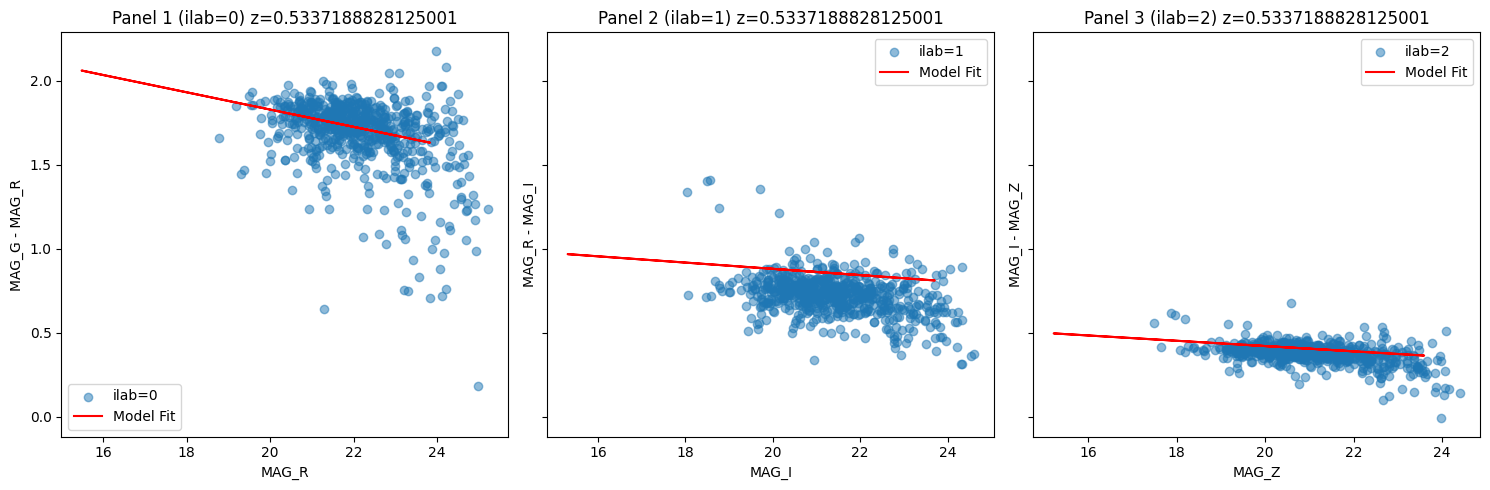

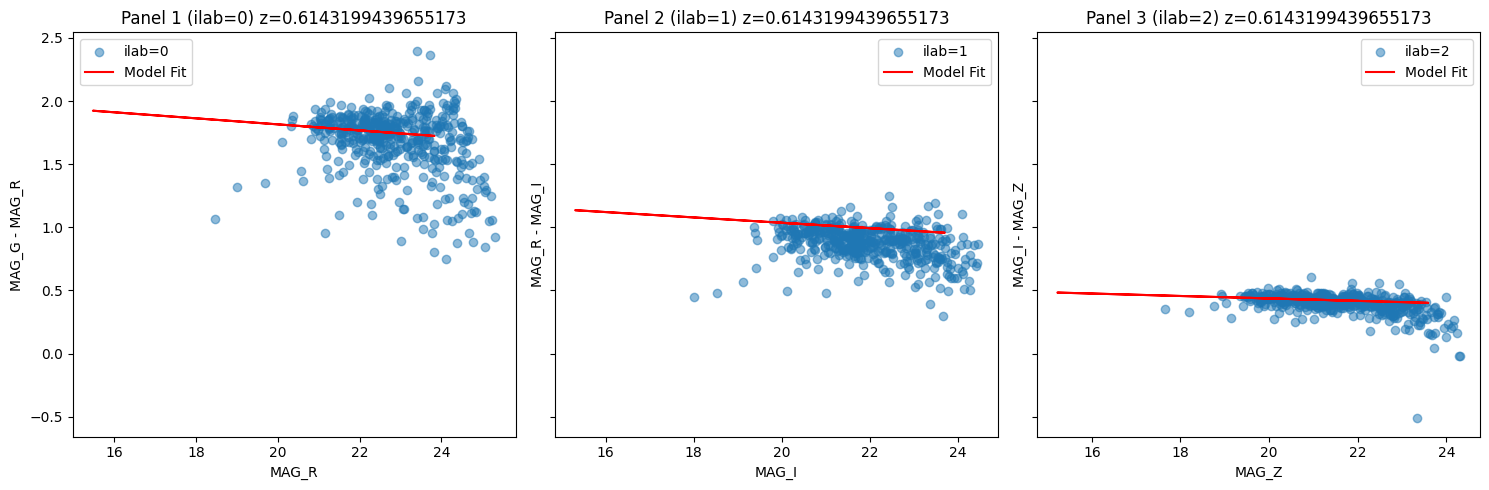

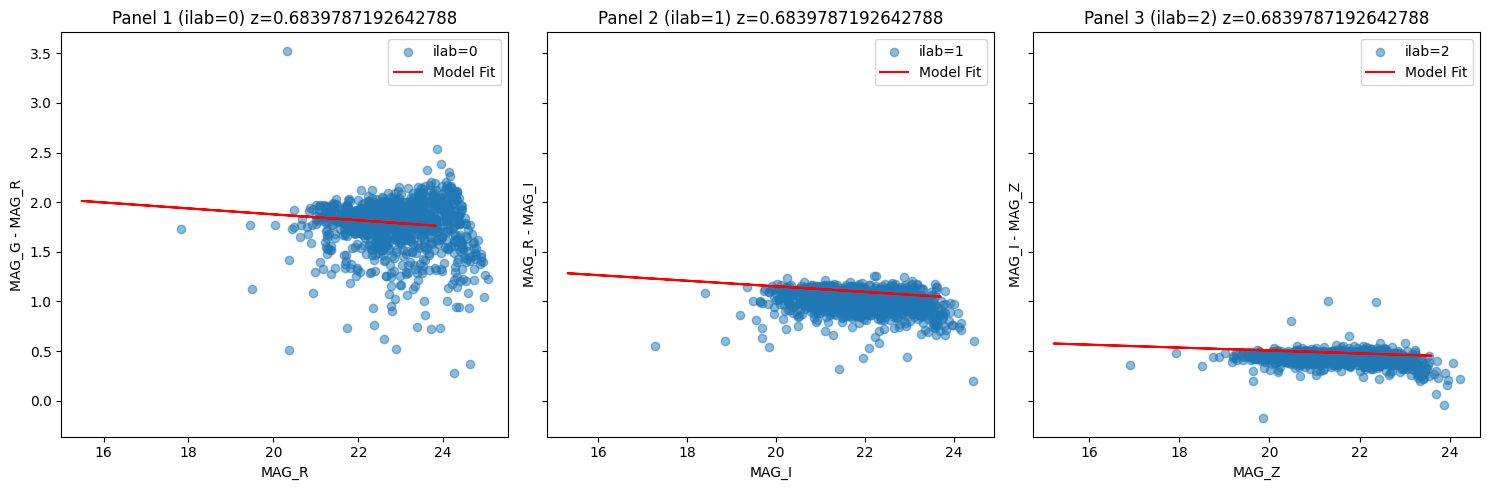

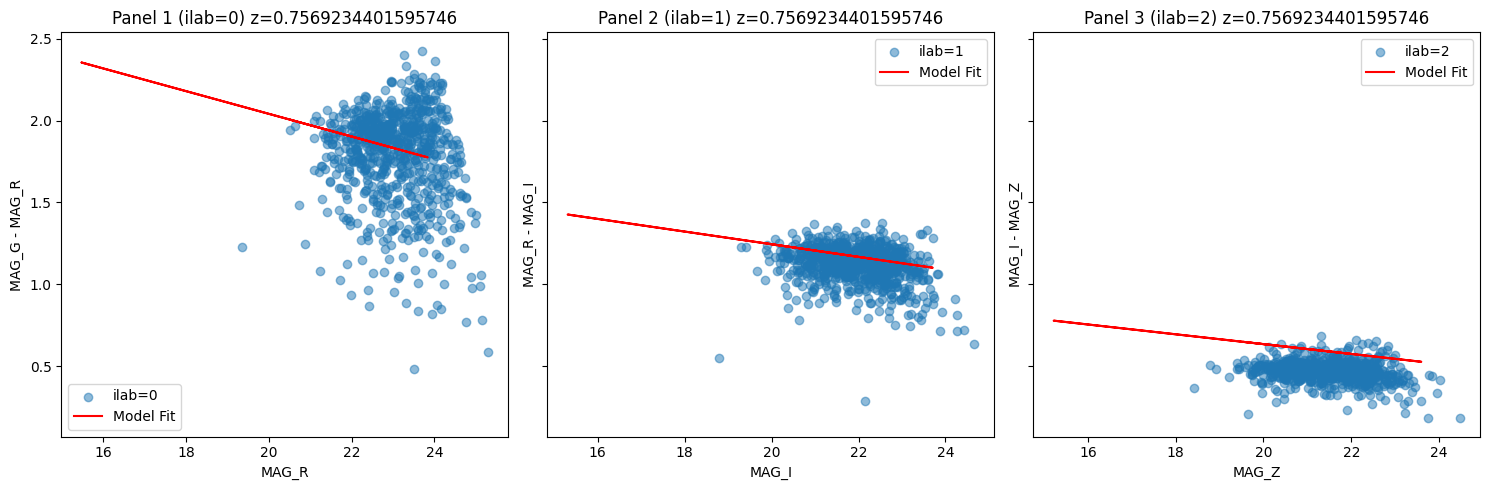

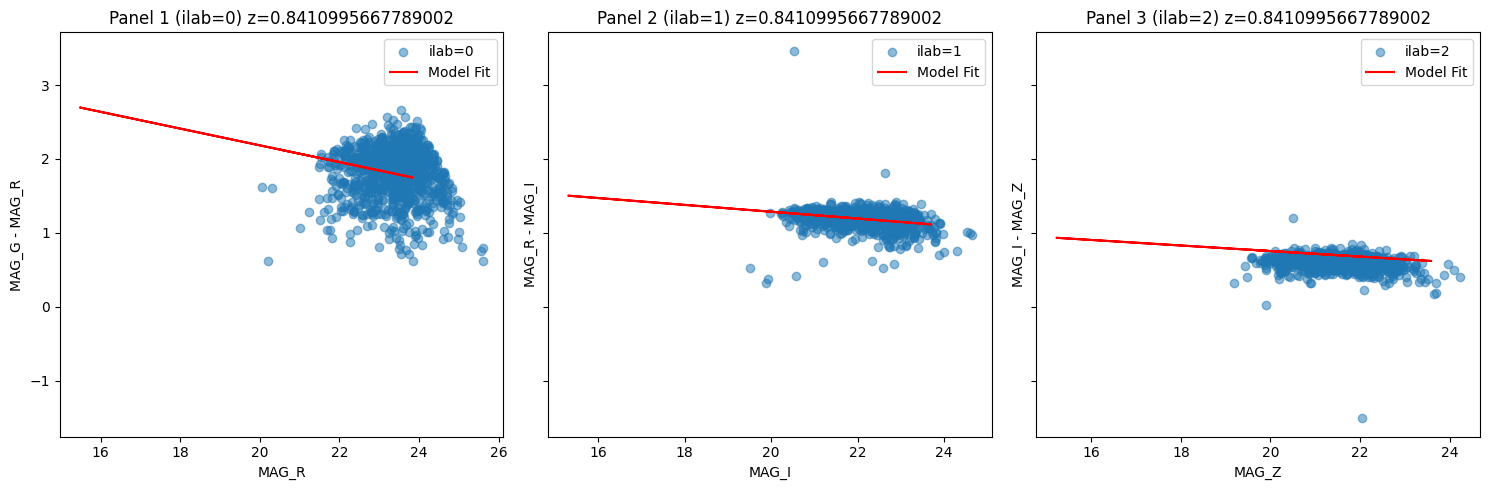

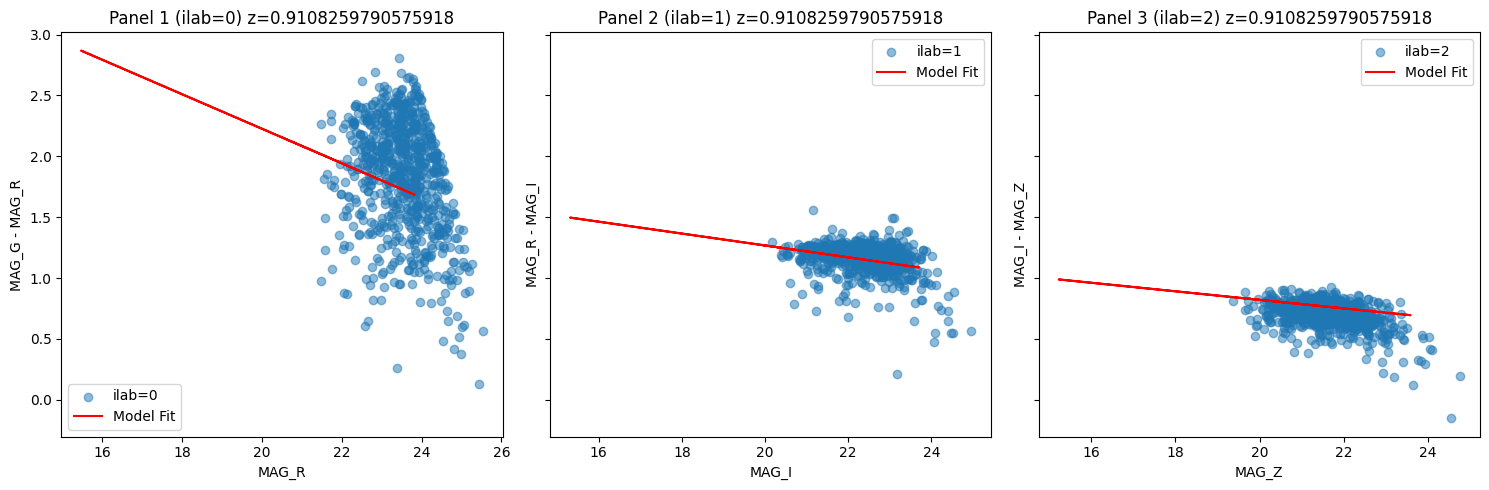

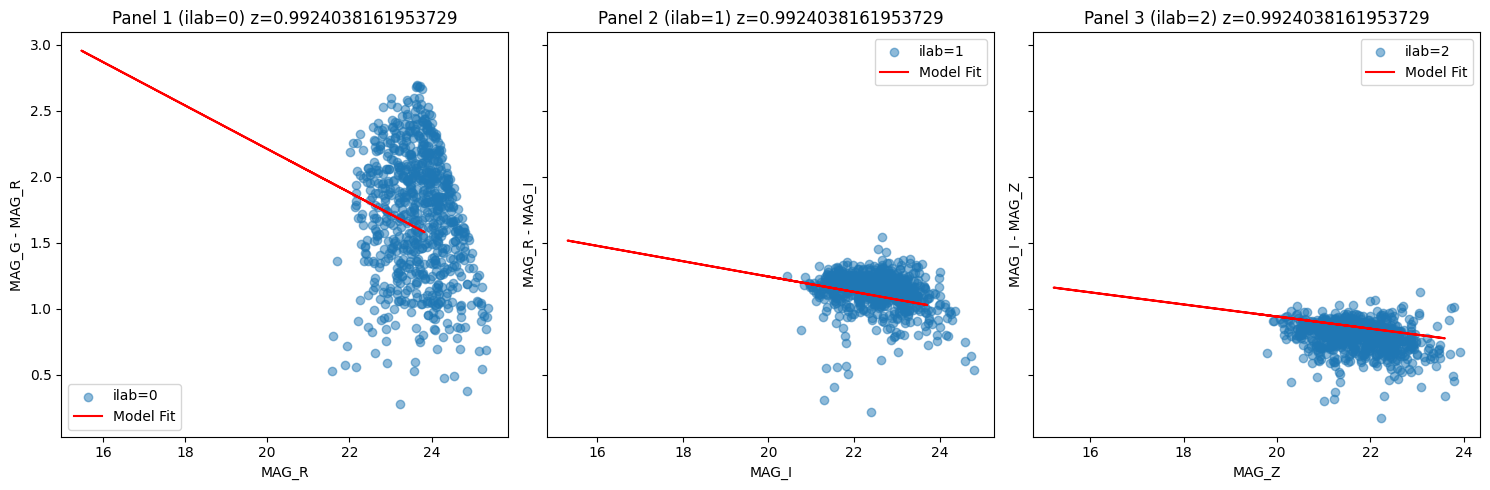

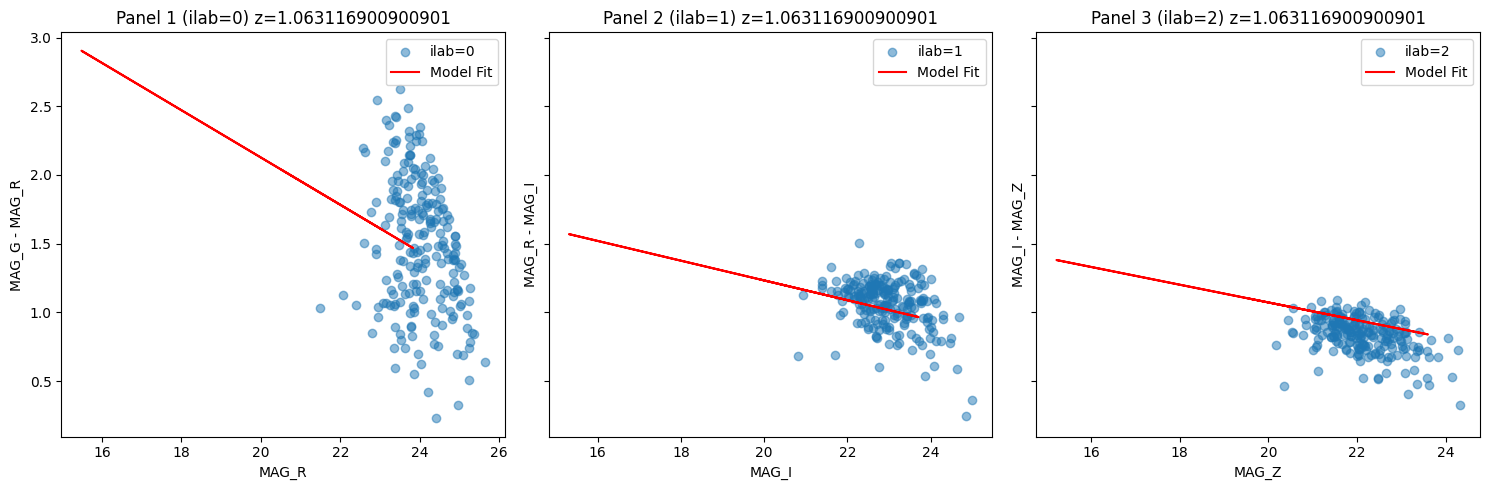

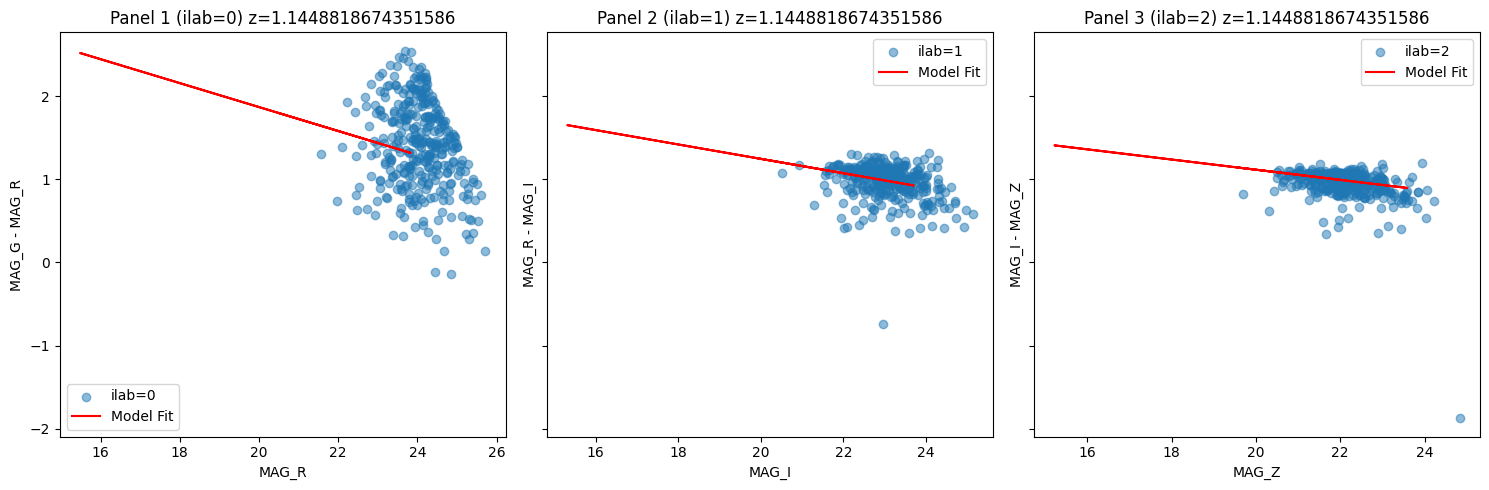

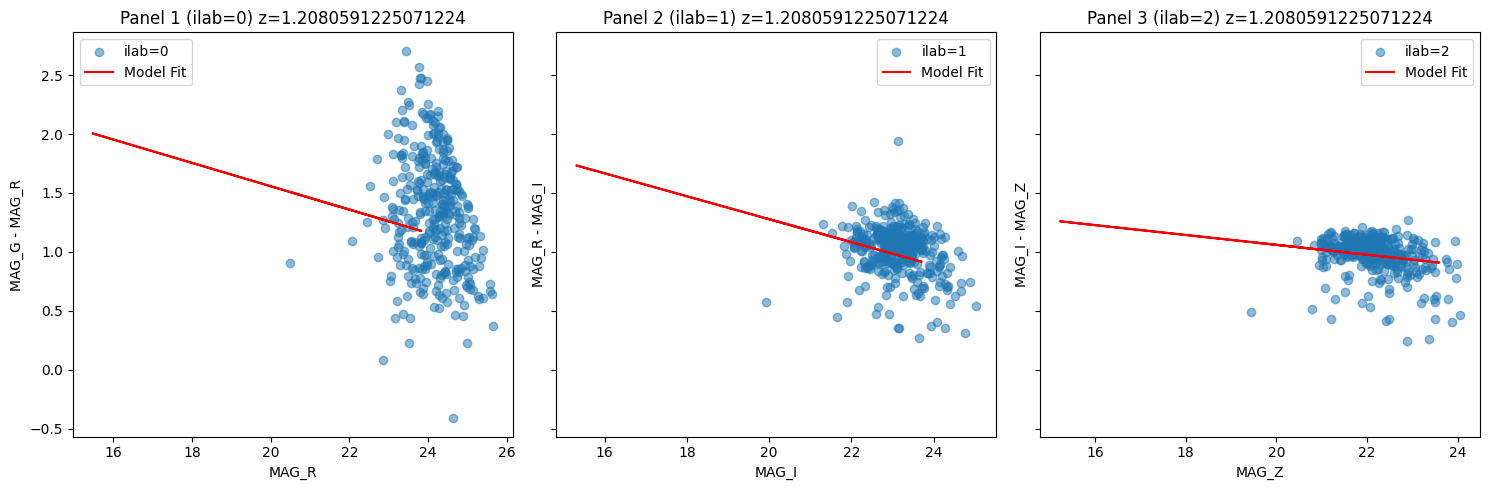

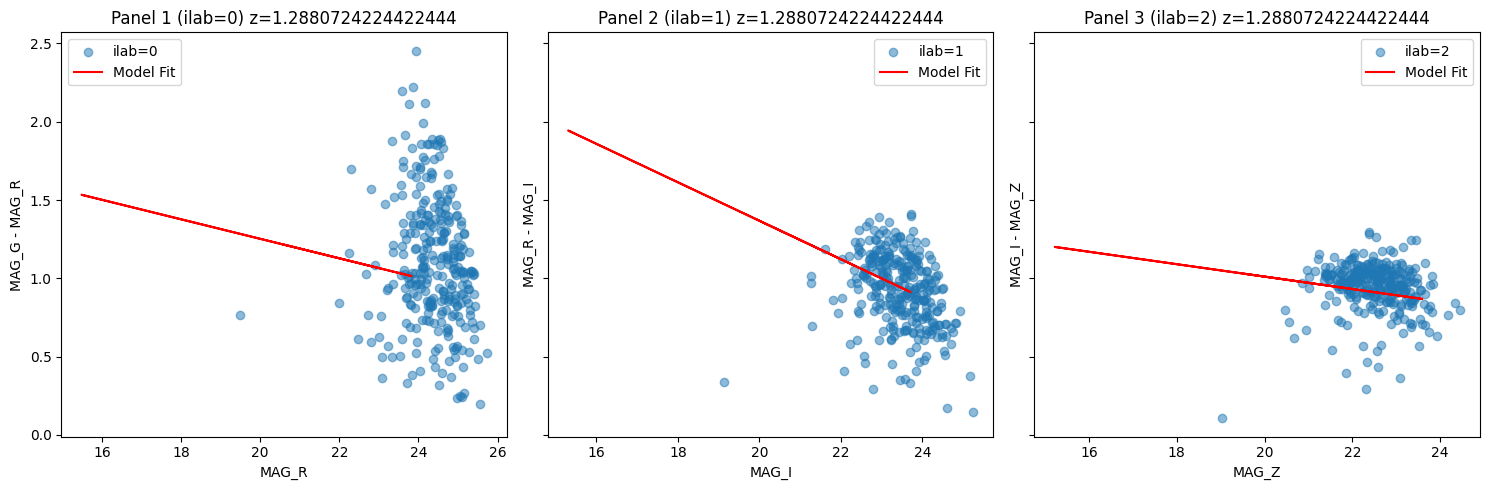

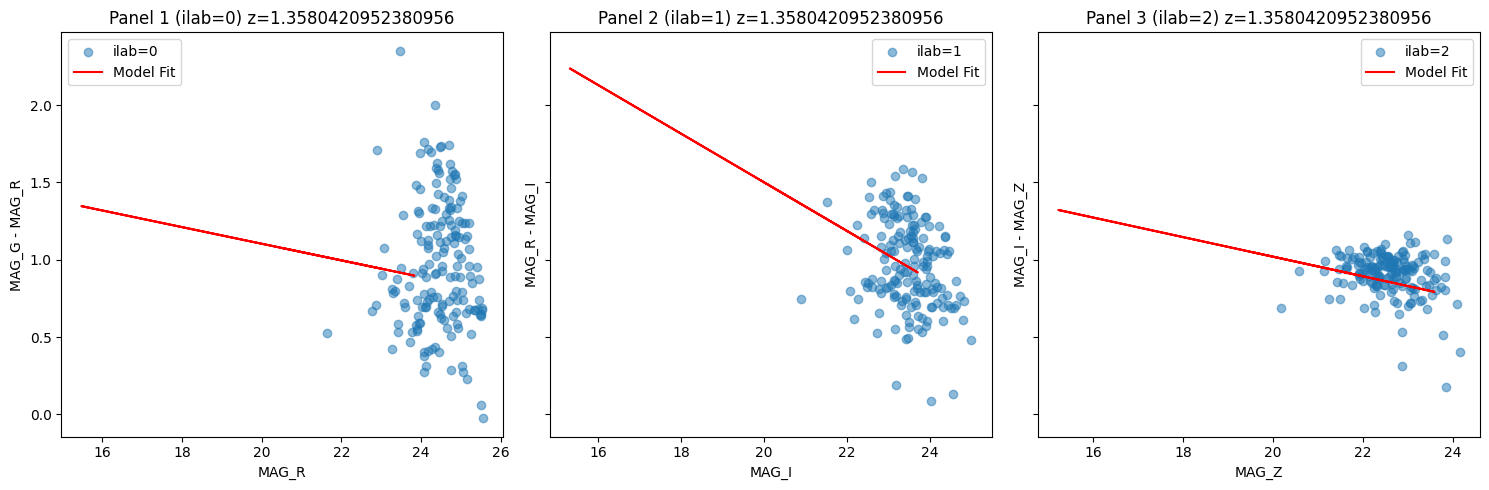

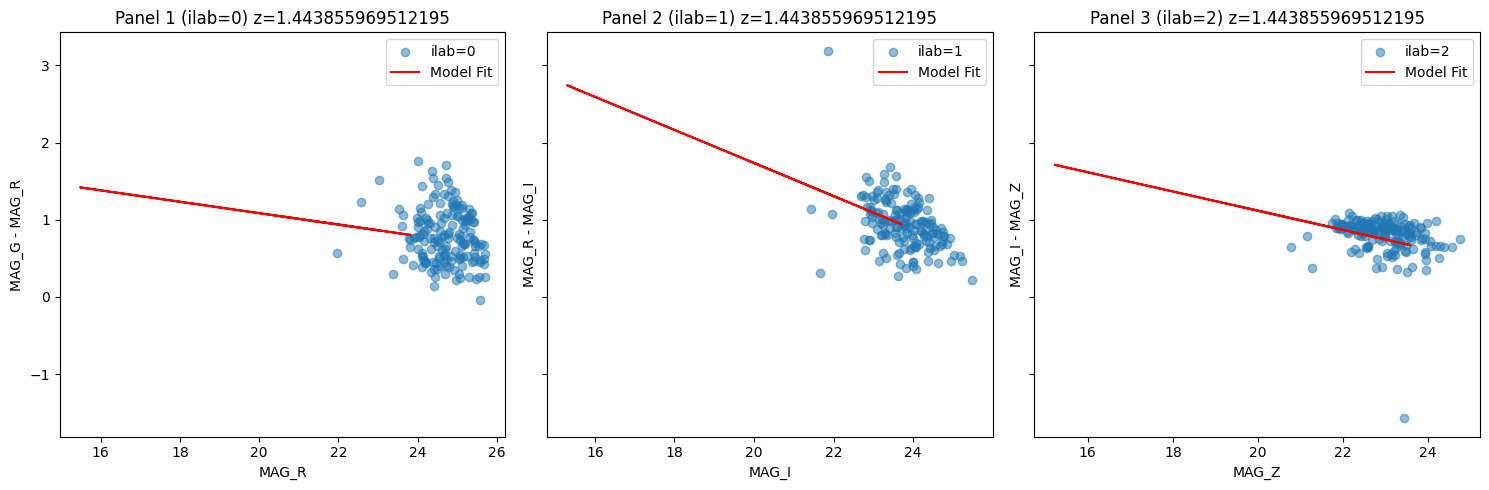

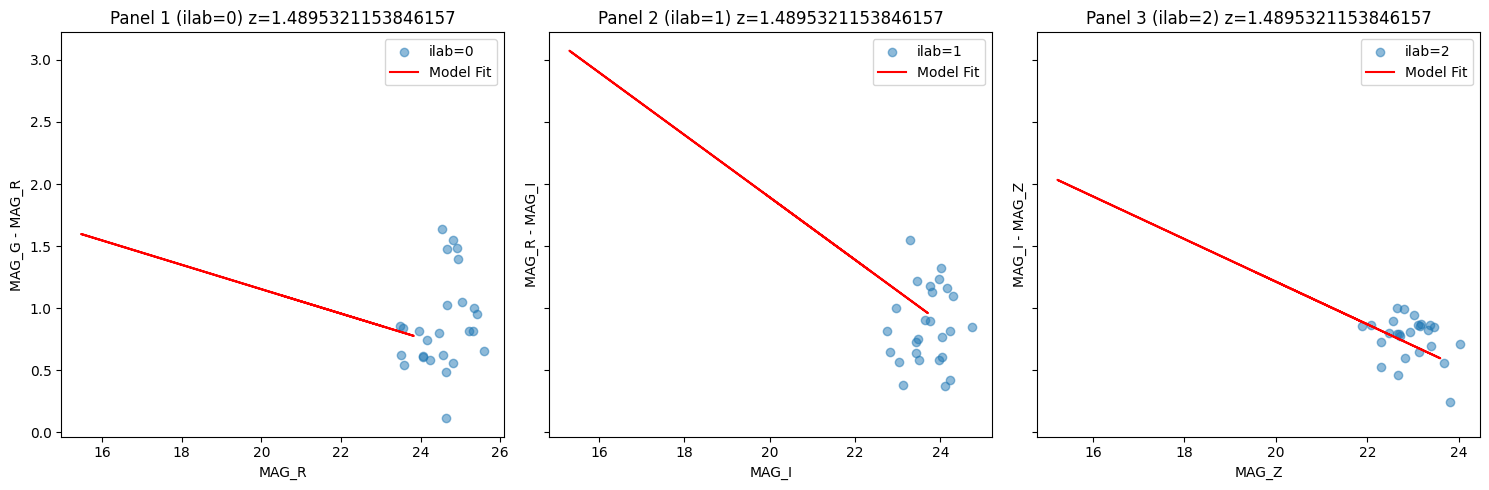

In [ ]:
zrange = np.arange(0.05,1.5,0.075)
dz = zrange[1]-zrange[0]

#plt.legend()
for i,j in enumerate(zrange):
    test = (cosmosm["EZzphot"]<j+dz) & (cosmosm["EZzphot"]>=j) & (cosmosm["passive"])
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    for ilab in range(3):
        x = desm[MLAB[ilab + 1]][test]
        y = desm[MLAB[ilab]][test] - desm[MLAB[ilab + 1]][test]
        xmod, ymod, s = model(np.mean(cosmosm["EZzphot"][test]), ilab)

        ax = axes[ilab]
        ax.scatter(x, y, alpha=0.5, label=f'ilab={ilab}')
        ax.plot(xmod, ymod, color='red', label='Model Fit')
        ax.set_title(f'Panel {ilab + 1} (ilab={ilab}) z='+str(np.mean(cosmosm["EZzphot"][test])))
        ax.set_xlabel(MLAB[ilab + 1])
        ax.set_ylabel(f'{MLAB[ilab]} - {MLAB[ilab + 1]}')
        ax.legend()

    plt.tight_layout()
    plt.show()



In [ ]:
filt = [(398,548),(568,716),(710,857),(850,1002)]
for i in filt:
    print(i[0]/400.-1,i[1]/400.-1)

-0.0050000000000000044 0.3700000000000001
0.41999999999999993 0.79
0.7749999999999999 1.1425
1.125 1.505


In [ ]:
spt = Table.read("/content/drive/My Drive/ObservationalCosmology/Photo-z/SPTpol_500d_catalog_tablevOct3.fits")

In [ ]:
spt[spt["XI"]>10]

SPT_ID,RA,DEC,FIELD,XI,THETA_CORE,REDSHIFT,REDSHIFT_UNC,SPECZ,M500,M500_UERR,M500_LERR,LAMBDA,LAMBDA_UNC,CONTAMINATION,SPITZER,RADIO_FLAG_RC,REDSHIFT_LL,LOS,LAMBDA2,LAMBDA2_UNC,Z2,Z2_UNC,CONTAMINATION2,UNCONFIRMED_LAMBDA,UNCONFIRMED_LAMBDA_UNC,UNCONFIRMED_Z,UNCONFIRMED_Z_UNC,UNCONFIRMED_CONTAMINATION
bytes16,float64,float64,bytes11,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
SPT-CLJ0000-5748,0.24789272,-57.808261,SPTpol_500d,14.584006,0.25,0.7019,0.0,1,5.115386,0.56388634,0.69250304,85.42216,9.554702,0.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SPT-CLJ0014-4952,3.7041663,-49.877617,SPTpol_500d,14.484389,0.25,0.752,0.0,1,5.0192423,0.54098684,0.67872494,98.37034,11.249337,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SPT-CLJ0019-5527,4.8269499,-55.45247,SPTpol_500d,12.938057,0.25,0.93235,0.02508867,0,4.377925,0.51752174,0.61447203,52.83738,8.071576,0.0024566299,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SPT-CLJ0033-6326,8.4710576,-63.445606,SPTpol_500d,13.455971,0.5,0.5971,0.0,1,5.0330305,0.58263946,0.6980026,67.94377,8.313293,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SPT-CLJ0048-5244,12.088389,-52.747844,SPTpol_500d,15.448857,0.25,1.0289,0.024793347,0,4.7378645,0.51407623,0.63005835,71.714714,10.401046,0.0,0,0,0,1,11.358376,4.707831,0.626632,0.035706792,0.15348761,0.0,0.0,0.0,0.0,0.0
SPT-CLJ0048-6416,12.236163,-64.270935,SPTpol_500d,14.324795,0.25,0.91735,0.022775065,0,4.6971006,0.52126473,0.6343962,61.10279,8.527926,0.0011643057,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SPT-CLJ0049-5315,12.377693,-53.25271,SPTpol_500d,12.843694,0.25,0.7235,0.01478633,0,4.697028,0.52169865,0.6453462,86.86043,9.60773,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SPT-CLJ0058-6146,14.585794,-61.766713,SPTpol_500d,16.285604,0.25,0.86566,0.016963596,0,5.1671734,0.56232834,0.6756638,92.97058,10.152106,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SPT-CLJ0106-5355,16.570656,-53.927693,SPTpol_500d,11.631568,0.25,0.48273,0.012385791,0,4.795548,0.5495827,0.67654383,63.763905,8.170917,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
